In [17]:
import cv2
import torch
from model import ResNet50
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import time
from PIL import Image

In [2]:
import os 
print(os.environ.get('CUDA_PATH'))

C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1


In [3]:
torch.cuda.is_available() 

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
label = ['Minor', "Non_Minor"]

In [6]:
model = ResNet50(img_channel=3, num_classes=10).to(device)
PATH = "model.pth"
model = torch.jit.load(PATH,map_location=device,)
print(next(model.parameters()).size())

torch.Size([784, 3, 7, 7])


In [13]:
def pred(img):
    model = ResNet50(img_channel=3, num_classes=10).to(device)
    PATH = "model.pth"
    model = torch.jit.load(
            PATH,
            map_location=device,
        )
    model.eval().to(device)
    img = transforms.ToPILImage()(img)
    image = img.resize((200, 200))
    image = np.array(image)
    image = image.astype(np.float32) / 255.0
    image = torch.from_numpy(image).unsqueeze(0).permute(0, 3 , 2 ,1)
    image = image.to(device)
    out = model(image)
    pred = out.argmax(dim=1, keepdim=True).item()
    return pred

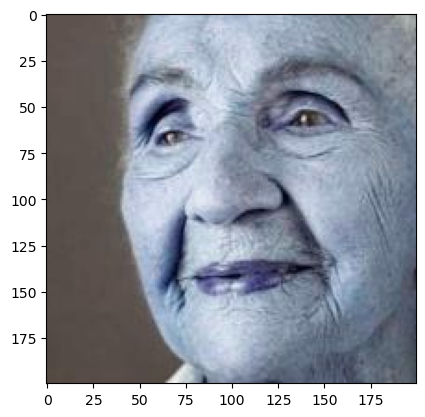

In [8]:
image = cv2.imread('image.jpg')
plt.imshow(image)


In [14]:
print(label[pred(image)])

Non_Minor


In [18]:


# Enable camera
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 420)
prev_frame = 0
new_frame = 0
# import cascade file for facial recognition
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


while True:
    success, img = cap.read()
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Getting corners around the face
    faces = faceCascade.detectMultiScale(imgGray, 1.3, 5)  # 1.3 = scale factor, 5 = minimum neighbor
    # drawing bounding box around face
    font  = cv2.FONT_HERSHEY_COMPLEX
    new_frame = time.time()
    fps = str(int(1/(new_frame - prev_frame)))
    prev_frame = new_frame
    cv2.putText(img, fps, (10, 70), font, 3, (0, 255, 0), 3, cv2.LINE_AA)
    for (x, y, w, h) in faces:
        predict = pred(img[y:y+h, x:x+w])
        if(label[predict]=='Minor'):
            face = img[y:y+h, x:x+w]
            blur = cv2.GaussianBlur(face, (99, 99),30)
            img[y:y+h, x:x+w] = blur




    cv2.imshow('face_detect', img)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyWindow('face_detect')